In [1]:
#######################
# IMPORTING LIBRARIES #
#######################

import pandas as pd
import numpy as np
from datetime import datetime

import pycountry  # To convert country names to 3 letter code
import webbrowser

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import pickle

In [2]:
################
# DATA PARSING #
################

# Functions for gathering datasets from John Hopkins's repository
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def worldData(fileName, columnName):
    data = pd.read_csv(base_url + fileName) \
             .melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='date', value_name=columnName) \
             .fillna('<all>')
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

def usData(fileName, columnName):
    data = pd.read_csv(base_url + fileName) \
             .melt(id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'], var_name='date', value_name=columnName) \
             .fillna('<all>')
    # Get names of indexes for which column Date has extra strings has value 30
    indexNames = data[data['date'] == 'Population'].index
    # Delete these row indexes from dataFrame
    data.drop(indexNames, inplace=True)
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

########################

# US data
us_data = usData("time_series_covid19_confirmed_US.csv", "Confirmed") \
    .merge(usData("time_series_covid19_deaths_US.csv", "Deaths"))
#us_data.head()

# World data
world_data = worldData("time_series_covid19_confirmed_global.csv", "Confirmed") \
    .merge(worldData("time_series_covid19_deaths_global.csv", "Deaths"))
#world_data.head()

########################

In [3]:
us_data.head()

UID iso2 iso3  code3  FIPS   Admin2            Province_State  \
0       316   GU  GUM    316    66    <all>                      Guam   
1       580   MP  MNP    580    69    <all>  Northern Mariana Islands   
2       630   PR  PRI    630    72    <all>               Puerto Rico   
3       850   VI  VIR    850    78    <all>            Virgin Islands   
4  84001001   US  USA    840  1001  Autauga                   Alabama   

  Country_Region        Lat       Long_                  Combined_Key  \
0             US  13.444300  144.793700                      Guam, US   
1             US  15.097900  145.673900  Northern Mariana Islands, US   
2             US  18.220800  -66.590100               Puerto Rico, US   
3             US  18.335800  -64.896300            Virgin Islands, US   
4             US  32.539527  -86.644082          Autauga, Alabama, US   

        date  Confirmed  Deaths  
0 2020-01-22          0       0  
1 2020-01-22          0       0  
2 2020-01-22          0       0  
3 2020-01-22          0       0  
4 2020-01-22          0       0

In [4]:
world_data.head()

Province/State Country/Region      Lat     Long       date  Confirmed  \
0          <all>    Afghanistan  33.0000  65.0000 2020-01-22          0   
1          <all>        Albania  41.1533  20.1683 2020-01-22          0   
2          <all>        Algeria  28.0339   1.6596 2020-01-22          0   
3          <all>        Andorra  42.5063   1.5218 2020-01-22          0   
4          <all>         Angola -11.2027  17.8739 2020-01-22          0   

   Deaths  
0       0  
1       0  
2       0  
3       0  
4       0

In [5]:
# Transforming datasets
grouped_countries = world_data.groupby(['date','Country/Region', 'Province/State']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
grouped_states = us_data.groupby([ 'date', 'Province_State', 'FIPS', 'Lat', 'Long_']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()

In [6]:
grouped_countries.head()

date Country/Region Province/State  Confirmed  Deaths
0 2020-01-22    Afghanistan          <all>          0       0
1 2020-01-22        Albania          <all>          0       0
2 2020-01-22        Algeria          <all>          0       0
3 2020-01-22        Andorra          <all>          0       0
4 2020-01-22         Angola          <all>          0       0

In [7]:
grouped_states.head()

date Province_State  FIPS        Lat      Long_  Confirmed  Deaths
0 2020-01-22        Alabama  1001  32.539527 -86.644082          0       0
1 2020-01-22        Alabama  1003  30.727750 -87.722071          0       0
2 2020-01-22        Alabama  1005  31.868263 -85.387129          0       0
3 2020-01-22        Alabama  1009  33.982109 -86.567906          0       0
4 2020-01-22        Alabama  1011  32.100305 -85.712655          0       0

In [8]:
# Opening pickled dictionary with demographics data of percentage of population over 65
with open('./pickled_files/age_dict.pkl', 'rb') as f:
    over_65_dict = pickle.load(f)
#over_65_dict

In [9]:
# Opening pickled dictionary with country data
with open('./pickled_files/dev_index_dict.pkl',  'rb') as f:
    dev_index_dict = pickle.load(f)
#dev_index_dict

In [10]:
##############################################
# CODE TO ADD COUNTRY CODES TO ALL COUNTRIES #
##############################################

# import pycountry # To convert country names to 3 letter code

# # Finding 3 letter codes of countries in our dataset
# input_countries = grouped_countries['Country/Region']

# countries = {}
# for country in pycountry.countries:
#     countries[country.name] = country.alpha_3

# codes = [countries.get(country, 'Unknown code') for country in input_countries]

# print(codes)
# grouped_countries['code'] = codes
# grouped_countries.head()

# # Generating a dictionary with countries and codes
# # First finding all countries with codes
# only_countries = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
# with_codes = only_countries[only_countries.code != 'Unknown code'][['Country/Region', 'code']]
# country_code_dict = dict(zip(with_codes['Country/Region'], with_codes['code']))

# with open('pickled_files/country_code_dict.pkl', 'wb') as f:
#     pickle.dump(country_code_dict, f)
# #country_code_dict

# # Checking for missing countries with missing codes
# no_codes = grouped_countries[grouped_countries.code == 'Unknown code'][['Country/Region']]
# countries_to_augment = no_codes['Country/Region'].unique()
# countries_to_augment

# Manually adding missing codes
# codes_to_add = ['BOL', 'BWN', 'MMR', 'COG', 'COD', 'CIV', 'UNK', 'VAT', 'IRN', 'KOR', 'RKS', 'LAO', 'UNK', 'MDA', 'RUS', 'SYR', 'TWN', 'TZA', 'USA', 'VEN', 'VNM', 'PSE']
# augmentation_dict = dict(zip(countries_to_augment, codes_to_add))
# #augmentation_dict

# # Augmenting previous dictionary
# complete_country_code_dict = {**augmentation_dict, **country_code_dict} 
# with open('pickled_files/complete_country_code_dict.pkl', 'wb') as f:
#     pickle.dump(complete_country_code_dict, f)

# #complete_country_code_dict


In [11]:
# Opening pickled country code dictionary
complete_country_code_dict = pd.read_pickle('pickled_files/complete_country_code_dict.pkl')

# Mapping codes to countries in dataset
grouped_countries['code'] = grouped_countries['Country/Region'].map(complete_country_code_dict)
# Double checking missing values
missing_codes = len(grouped_countries[grouped_countries.code == 'Unknown code'][['Country/Region']])
print(f'There are {missing_codes} missing 3-letter codes in dataset')
print('-------')
grouped_countries.head()

There are 0 missing 3-letter codes in dataset
-------


date Country/Region Province/State  Confirmed  Deaths code
0 2020-01-22    Afghanistan          <all>          0       0  AFG
1 2020-01-22        Albania          <all>          0       0  ALB
2 2020-01-22        Algeria          <all>          0       0  DZA
3 2020-01-22        Andorra          <all>          0       0  AND
4 2020-01-22         Angola          <all>          0       0  AGO

In [12]:
##############
# CHOROPLETH #
##############

global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()

# Adding Fatality Rates
global_data['fatalityRate'] = round(global_data.Deaths/global_data.Confirmed*100, 2)
#global_data.head()

def world_map():
    

    fig = px.choropleth(
                            global_data,
                            locations='code',
                            #title="Custom layout.hoverlabel formatting",
                            hover_name="Country/Region",
                            hover_data=["Confirmed", "Deaths"],
                            color=np.log10(global_data["Confirmed"]),
                            color_continuous_scale='Reds',
                            #range_color=(0, 100),
                            labels={
                                'Confirmed': 'Confirmed Cases <br> (x10) <br>',
                                'Deaths': 'Deaths'
                            },
                            #featureidkey="global_data.Deaths",
                            scope='world',
                            # animation_frame='date'
                       )
    fig.update_layout(template="plotly_dark", margin={
            "r": 0,
            "t": 0,
            "l": 0,
            "b": 0
        }, coloraxis_showscale=False,# Set to True to show colorscale bar
                          coloraxis_colorbar=dict(
                              title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
                              tickvals=[1.5, 2.5, 3.5, 4.5],
                              ticktext=["100", "1k", "10k", "100k"],
                              thicknessmode="pixels",
                              thickness=10,
                              lenmode="pixels",
                              len=200,
                          ),
                          hovermode="x",
                          hoverlabel=dict(
                              bgcolor="#BF4025",
                              font_size=16,
                          ),
                          geo=dict(showframe=False,
                                   showcoastlines=False,
                                   projection_type='natural earth'))

    fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
                          '</b>' + '<br>' + 'Confirmed Cases: ' +
                          global_data['Confirmed'].astype(str) + '<br>' +
                          'Deaths: ' + global_data['Deaths'].astype(str))
    return fig

In [13]:
#world_map()

In [14]:
###############
# TOTAL CASES #
###############

total_confirmed = global_data.Confirmed.sum()
total_deaths = global_data.Deaths.sum()
print(f'Total Confirmed Cases: {total_confirmed}')
print(f'Total Deaths: {total_deaths}')

Total Confirmed Cases: 1397409
Total Deaths: 81464


In [15]:
################
# LAST UPDATED #
################
last_update = grouped_countries.date.max()
# conv_date = datetime.strptime(last_update, '%d/%m/%y')
print(last_update)

2020-04-07 00:00:00


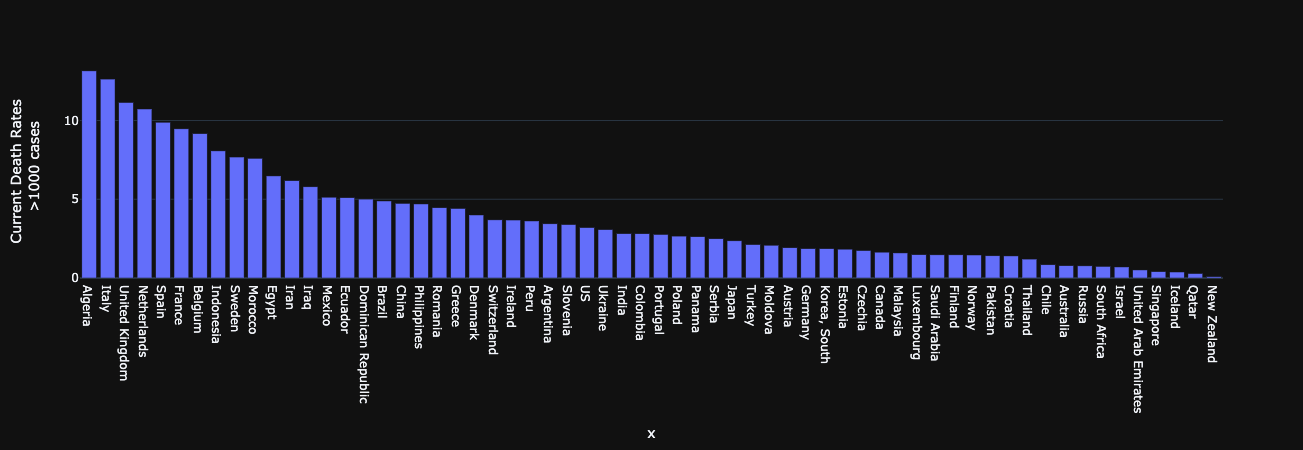

In [16]:
##############
# BAR CHARTS #
##############



# Limiting graph to countries with more than 1000 cases

x = global_data[global_data.Confirmed > 1000]["Country/Region"]
y = global_data[global_data.Confirmed > 1000]["fatalityRate"]

fig = px.bar(global_data, x=x, y=y)
fig.update_layout(xaxis={'categoryorder':'total descending'}, template="plotly_dark", yaxis={'title': 'Current Death Rates <br> >1000 cases'})
fig.show()

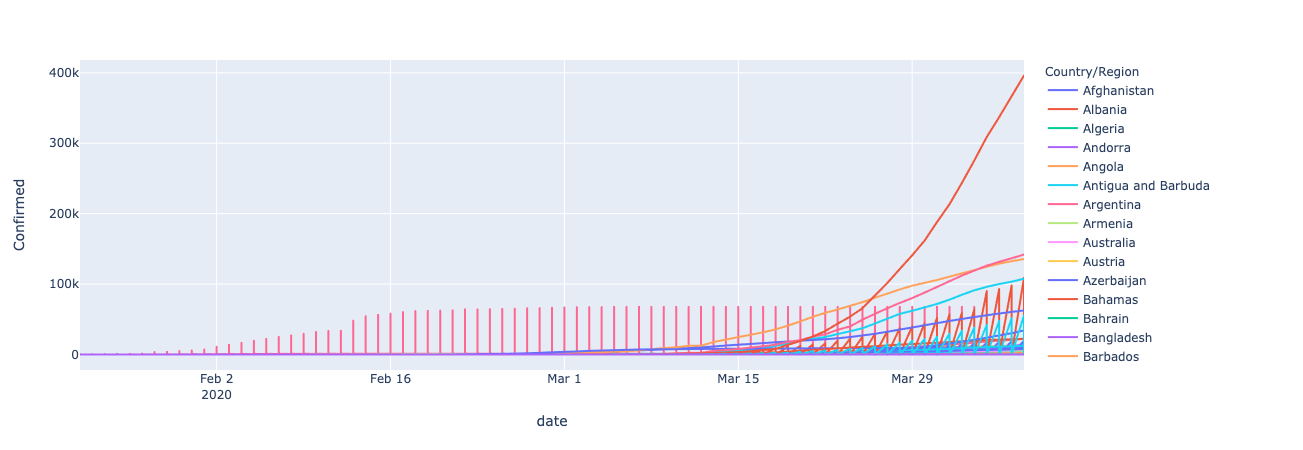

In [17]:
fig = px.line(grouped_countries, x="date", y="Confirmed", color='Country/Region')
fig.show()

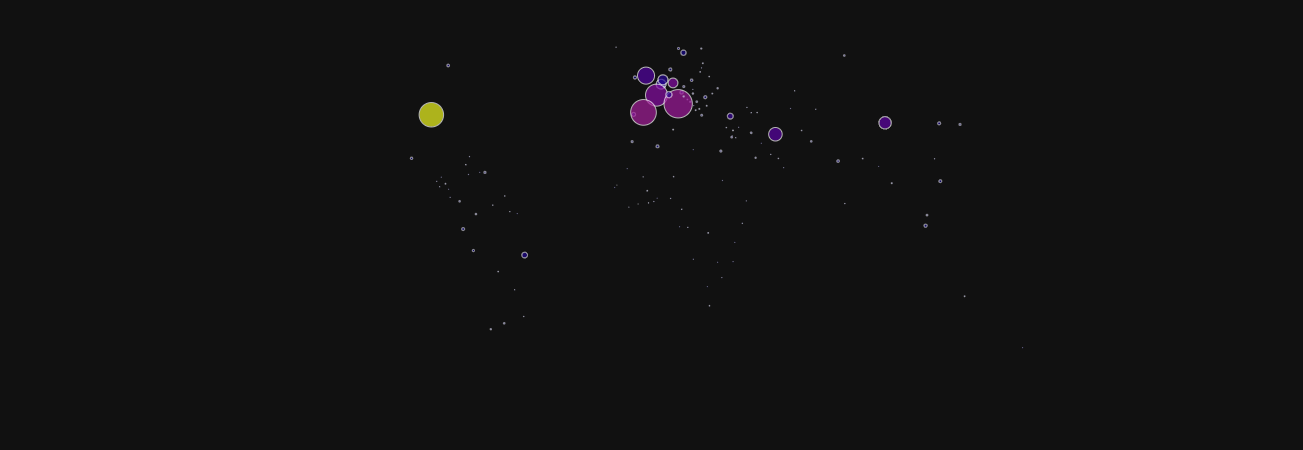

In [18]:
global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
fig = px.scatter_geo(global_data, locations="code", color="Confirmed",
                     hover_name="Country/Region", size="Deaths",
                     projection="natural earth")

fig.update_layout(template="plotly_dark", margin={
            "r": 0,
            "t": 0,
            "l": 0,
            "b": 0
        },coloraxis_showscale=False,
                          coloraxis_colorbar=dict(
#                               title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
#                               tickvals=[1.5, 2.5, 3.5, 4.5],
#                               ticktext=["100", "1k", "10k", "100k"],
                              thicknessmode="pixels",
                              thickness=10,
                              lenmode="pixels",
                              len=200,
                          ),
                          hovermode="x",
                          hoverlabel=dict(
                              bgcolor="#BF4025",
                              font_size=16,
                          ),
                          geo=dict(showframe=False,
                                   showcoastlines=False,
                                   projection_type='natural earth'))

fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
                          '</b>' + '<br>' + 'Confirmed Cases: ' +
                          global_data['Confirmed'].astype(str) + '<br>' +
                          'Deaths: ' + global_data['Deaths'].astype(str))

fig.show()

In [19]:
global_data.head()

Country/Region code  Confirmed  Deaths
0    Afghanistan  AFG        423      14
1        Albania  ALB        383      22
2        Algeria  DZA       1468     193
3        Andorra  AND        545      22
4         Angola  AGO         17       2

In [20]:
# days = list(grouped_countries.date)

# # make list of countries
# countries = []
# for c in grouped_countries["Country/Region"]:
#     if c not in countries:
#         countries.append(c)
# # make figure
# fig_dict = {
#     "data": [],
#     "layout": {},
#     "frames": []
# }

# # fill in most of layout
# fig_dict["layout"]["xaxis"] = {"range": [30, 85], "title": "Life Expectancy"}
# fig_dict["layout"]["yaxis"] = {"title": "GDP per Capita", "type": "log"}
# fig_dict["layout"]["hovermode"] = "closest"
# fig_dict["layout"]["sliders"] = {
#     "args": [
#         "transition", {
#             "duration": 400,
#             "easing": "cubic-in-out"
#         }
#     ],
#     "initialValue": "1952",
#     "plotlycommand": "animate",
#     "values": days,
#     "visible": True
# }
# fig_dict["layout"]["updatemenus"] = [
#     {
#         "buttons": [
#             {
#                 "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                 "fromcurrent": True, "transition": {"duration": 300,
#                                                                     "easing": "quadratic-in-out"}}],
#                 "label": "Play",
#                 "method": "animate"
#             },
#             {
#                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                   "mode": "immediate",
#                                   "transition": {"duration": 0}}],
#                 "label": "Pause",
#                 "method": "animate"
#             }
#         ],
#         "direction": "left",
#         "pad": {"r": 10, "t": 87},
#         "showactive": False,
#         "type": "buttons",
#         "x": 0.1,
#         "xanchor": "right",
#         "y": 0,
#         "yanchor": "top"
#     }
# ]

# sliders_dict = {
#     "active": 0,
#     "yanchor": "top",
#     "xanchor": "left",
#     "currentvalue": {
#         "font": {"size": 20},
#         "prefix": "Day:",
#         "visible": True,
#         "xanchor": "right"
#     },
#     "transition": {"duration": 300, "easing": "cubic-in-out"},
#     "pad": {"b": 10, "t": 50},
#     "len": 0.9,
#     "x": 0.1,
#     "y": 0,
#     "steps": []
# }

# # make data
# day = '1/22/20'
# for c in countries:
#     dataset_by_day = grouped_countries[grouped_countries["date"] == day]
#     dataset_by_day_and_cont = dataset_by_day[
#         dataset_by_day["Country/Region"] == c]

#     data_dict = {
#         "x": list(dataset_by_day_and_cont["date"]),
#         "y": list(dataset_by_day_and_cont["Confirmed"]),
#         "mode": "markers",
# #         "text": list(dataset_by_day_and_cont["country"]),
# #         "marker": {
# #             "sizemode": "area",
# #             "sizeref": 200000,
# #             "size": list(dataset_by_day_and_cont["pop"])
# #         },
#         "name": c
#     }
#     fig_dict["data"].append(data_dict)

# # make frames
# for d in days:
#     frame = {"data": [], "name": str(d)}
#     for c in countries:
#         dataset_by_day = grouped_countries[grouped_countries["date"] == d]
#         dataset_by_day_and_cont = dataset_by_day[
#             dataset_by_day["Country/Region"] == c]

#         data_dict = {
#             "x": list(dataset_by_day_and_cont["date"]),
#             "y": list(dataset_by_day_and_cont["Confirmed"]),
#             "mode": "markers",
#             "text": list(dataset_by_day_and_cont["Country/Region"]),
#             "marker": {
#                 "sizemode": "area",
#                 "sizeref": 200000,
#                 "size": list(dataset_by_day_and_cont["Confirmed"])
#             },
#             "name": c
#         }
#         frame["data"].append(data_dict)

#     fig_dict["frames"].append(frame)
#     slider_step = {"args": [
#         [day],
#         {"frame": {"duration": 300, "redraw": False},
#          "mode": "immediate",
#          "transition": {"duration": 300}}
#     ],
#         "label": day,
#         "method": "animate"}
#     sliders_dict["steps"].append(slider_step)


# fig_dict["layout"]["sliders"] = [sliders_dict]

# fig = go.Figure(fig_dict)

# fig.show()

In [21]:
# fig = go.Figure(
#     data=[go.Scatter(x=[0, 1], y=[0, 1])],
#     layout=go.Layout(
#         xaxis=dict(range=[0, 5], autorange=False),
#         yaxis=dict(range=[0, 5], autorange=False),
#         title="Start Title",
#         updatemenus=[dict(
#             type="buttons",
#             buttons=[dict(label="Play",
#                           method="animate",
#                           args=[None])])]
#     ),
#     frames=[go.Frame(data=[go.Scatter(x=[1, 2], y=[1, 2])]),
#             go.Frame(data=[go.Scatter(x=[1, 4], y=[1, 4])]),
#             go.Frame(data=[go.Scatter(x=[3, 4], y=[3, 4])],
#                      layout=go.Layout(title_text="End Title"))]
# )

# fig.show()

In [22]:
# global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
# global_data['deathRate'] = global_data['Deaths']/global_data['Confirmed']
# death_rates = global_data[(global_data['Deaths'] > 0) & (global_data['Confirmed'] >1000)]

# # Country
# # country = grouped_country['Country/Region']


# # Initialize figure with subplots
# fig = make_subplots(
#     rows=2, cols=2,
#     column_widths=[0.6, 0.4],
#     row_heights=[0.5, 0.5],
#     specs=[[{"type": "choropleth", "rowspan":2}, {"type": "bar"}],
#            [                 None               , {"type": "surface"}]])

# # fig.add_trace(
# #     px.choropleth(grouped_countries, locations='code',
# #                     hover_data=["Confirmed", "Deaths"],
# #                     color='Confirmed',
# #                     range_color=(0, 25000),
# #                     color_continuous_scale='orrd', 
# #                     labels={'Confirmed': 'Confirmed Cases (x10)', 'Deaths': 'Deaths'}, 
# #                     featureidkey="grouped_countries.Deaths",
# #                     scope='world'))

# # Add scattergeo globe map
# fig.add_trace(
#     go.Choropleth(
#         locations = global_data['code'],
#         z = global_data['Confirmed'],
# #         text = global_data['Deaths'],
#         colorscale = 'Reds',
#         autocolorscale=False,
#         reversescale=False,
#         marker_line_color='white',
#         marker_line_width=0.2,
#         colorbar_tickprefix = '',
#         colorbar_title = ''
#     ), row=1, col=1
# )

# #Add death rate bar chart
# fig.add_trace(
#     go.Bar(x=death_rates["Country/Region"],y=death_rates["deathRate"], marker=dict(color="crimson"), showlegend=False),
#     row=1, col=2
# )


# fig.update_layout(template="plotly_dark", showlegend=False, xaxis={'categoryorder':'total descending'},
#     annotations=[
#         dict(
# text="Data sources: WHO, CDC, ECDC, NHC, DXY, 1point3acres, Worldometers.info, BNO, state and national government health departments, and local media reports.",
#             showarrow=False,
#             xref="paper",
#             yref="paper",
#             x=0,
#             y=0)
#     ],
#         coloraxis_showscale=False, 
#         margin={
#         "r": 0,
#         "t": 20,
#         "l": 0,
#         "b": 0
#     },
#         coloraxis_colorbar=dict(
#             title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
#             tickvals=[1.5, 2.5, 3.5, 4.5],
#             ticktext=["100", "1k", "10k", "100k"],
#             thicknessmode="pixels",
#             thickness=10,
#             lenmode="pixels",
#             len=200,
#                       ),
#         hovermode="x",
#         hoverlabel=dict(
#             bgcolor="#BF4025",
#             font_size=16,
#                       )
#                  )

# # Update geo subplot properties
# fig.update_geos(
#     projection_type="natural earth",
#     landcolor="lightgrey",
#     oceancolor="MidnightBlue",
#     showocean=False,
#     lakecolor="white",
#     showframe=False,
#     showcoastlines=True,
#     coastlinewidth=0.2
# )


# # # Add 3d surface of volcano
# # fig.add_trace(
# #     go.Surface(z=df_v.values.tolist(), showscale=False),
# #     row=2, col=2
# # )


# # # Rotate x-axis labels
# fig.update_xaxes()
# fig.update_yaxes(title="Current Death Rates <br> (>1000 cases)}", tickfont=dict(family='Rockwell', color='crimson', size=10))

# #Set theme, margin, and annotation in layout
# # fig.update_layout(showlegend=False, xaxis={'categoryorder':'total descending'}, coloraxis_showscale=False,
# # #             coloraxis_colorbar=dict(
# # #     title="Number of Bills per Cell",
# # #     thicknessmode="pixels", thickness=10,
# # #     lenmode="pixels", len=50,
# # #     yanchor="top", y=1,
# # #     ticks="outside", ticksuffix=" bills",
# # #     dtick=5),      
# #     template="plotly_dark",
# #     margin=dict(r=0, t=0, b=0, l=0),
# #     annotations=[
# #         dict(
# # text="Source: mjkjk",
# #             showarrow=False,
# #             xref="paper",
# #             yref="paper",
# #             x=0,
# #             y=0)
# #     ]
# # )
# fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
#                       '</b>' + '<br>' + 'Confirmed Cases: ' +
#                       [str((f"{num:,d}")) for num in global_data['Confirmed']] + '<br>' +
#                       'Deaths: ' + [str((f"{num:,d}")) for num in global_data['Deaths']] + '<br>' + 
#                       'Current Death Rate: ' + [str(round(num*100, 2)) for num in global_data['deathRate']] + '%' + 
#                       '<extra></extra>')


In [23]:
#################################
########## VERSION 2 ############


In [24]:
def world_data():
    data=pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
    return data

In [25]:
df = world_data()
df.head()

Date      Country  Confirmed  Recovered  Deaths
0 2020-01-22  Afghanistan          0          0       0
1 2020-01-22      Albania          0          0       0
2 2020-01-22      Algeria          0          0       0
3 2020-01-22      Andorra          0          0       0
4 2020-01-22       Angola          0          0       0

In [26]:
df

Date             Country  Confirmed  Recovered  Deaths
0     2020-01-22         Afghanistan          0          0       0
1     2020-01-22             Albania          0          0       0
2     2020-01-22             Algeria          0          0       0
3     2020-01-22             Andorra          0          0       0
4     2020-01-22              Angola          0          0       0
...          ...                 ...        ...        ...     ...
14163 2020-04-07             Vietnam        249        123       0
14164 2020-04-07  West Bank and Gaza        261         42       1
14165 2020-04-07      Western Sahara          4          0       0
14166 2020-04-07              Zambia         39          7       1
14167 2020-04-07            Zimbabwe         11          0       2

[14168 rows x 5 columns]

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
# %matplotlib inline #if you're working in a Jupyter notebook

# Section 2 - Loading and Selecting Data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
countries = ['Canada', 'Germany', 'United Kingdom', 'US', 'France', 'China', 'Spain']
df_select = df[df['Country'].isin(countries)].copy()

# Section 3 - Creating a Summary Column
df_select['Cases'] = df_select[['Confirmed']].sum(axis=1)

# Section 4 - Restructuring our Data
df_select = df_select.pivot(index='Date', columns='Country', values='Cases')
countries = list(df_select.columns)
covid = df_select.reset_index('Date')
covid.set_index(['Date'], inplace=True)
covid.columns = countries

# Section 5 - Calculating Rates per 100,000
populations = {'Canada':37664517, 'Germany': 83721496 , 'United Kingdom': 67802690 , 'US': 330548815, 'France': 65239883, 'China':1438027228, 'Spain': 46940000}
percapita = covid.copy()
for country in list(percapita.columns):
    percapita[country] = percapita[country]/populations[country]*100000

In [28]:
df_select.head()

Country     Canada  China  France  Germany  Spain  US  United Kingdom
Date                                                                 
2020-01-22       0    548       0        0      0   1               0
2020-01-23       0    643       0        0      0   1               0
2020-01-24       0    920       2        0      0   2               0
2020-01-25       0   1406       3        0      0   2               0
2020-01-26       1   2075       3        0      0   5               0

In [29]:
# Opening pickled dictionary with population data and mapping to countries
pop_dict = pd.read_pickle('./pickled_files/population_dict.pkl')
# Mapping populations to countries in dataset
df['population'] = df['Country'].map(pop_dict)
# Double checking missing values
missing_populations = len(df[df.population.isna()][['population']])
print(f'There are {missing_populations} missing populations in dataset')
print('-------')
df.head()

There are 1540 missing populations in dataset
-------


Date      Country  Confirmed  Recovered  Deaths  population
0 2020-01-22  Afghanistan          0          0       0   38928.346
1 2020-01-22      Albania          0          0       0    2877.797
2 2020-01-22      Algeria          0          0       0   43851.044
3 2020-01-22      Andorra          0          0       0      77.265
4 2020-01-22       Angola          0          0       0   32866.272

In [30]:
df['confirmedPerCapita'] = df.Confirmed/df.population*100000
df['deathPerCapita'] = df.Deaths/df.population*100000
df.head()

Date      Country  Confirmed  Recovered  Deaths  population  \
0 2020-01-22  Afghanistan          0          0       0   38928.346   
1 2020-01-22      Albania          0          0       0    2877.797   
2 2020-01-22      Algeria          0          0       0   43851.044   
3 2020-01-22      Andorra          0          0       0      77.265   
4 2020-01-22       Angola          0          0       0   32866.272   

   confirmedPerCapita  deathPerCapita  
0                 0.0             0.0  
1                 0.0             0.0  
2                 0.0             0.0  
3                 0.0             0.0  
4                 0.0             0.0

Text(2020-01-23 00:00:00, -100000, 'datagy.io                      Source: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv')

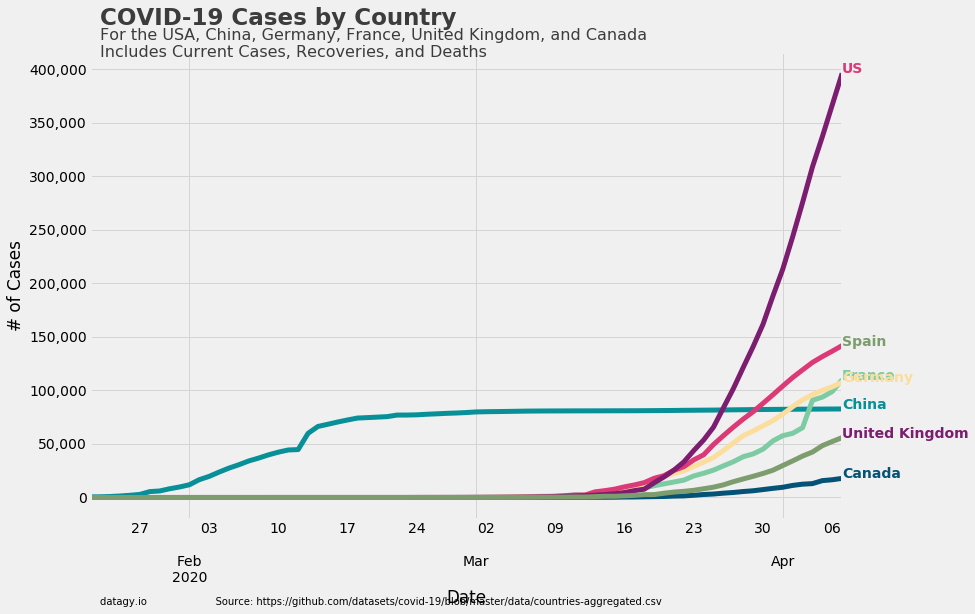

In [31]:
# Section 6 - Generating Colours and Style
colors = {'Canada':'#045275', 'China':'#089099', 'France':'#7CCBA2', 'Germany':'#FCDE9C', 'US':'#DC3977', 'United Kingdom':'#7C1D6F', 'Spain':'#7D9D6F'}
plt.style.use('fivethirtyeight')

# Section 7 - Creating the Visualization
plot = covid.plot(figsize=(12,8), color=list(colors.values()), linewidth=5, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Section 8 - Assigning Colour
for country in list(colors.keys()):
    plot.text(x = covid.index[-1], y = covid[country].max(), c = colors[country], s = country, weight = 'bold')

# Section 9 - Adding Labels
plot.text(x = covid.index[1], y = int(covid.max().max())+45000, s = "COVID-19 Cases by Country", fontsize = 23, weight = 'bold', alpha = .75)
plot.text(x = covid.index[1], y = int(covid.max().max())+15000, s = "For the USA, China, Germany, France, United Kingdom, and Canada\nIncludes Current Cases, Recoveries, and Deaths", fontsize = 16, alpha = .75)
plot.text(x = percapita.index[1], y = -100000,s = 'datagy.io                      Source: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv', fontsize = 10)


In [32]:
countries = df.Country.unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [33]:
#sorting based on confirmed cases to identify top-10 countries with highest confirmed cases
grouped = df.groupby(['Country']).agg({'Confirmed': 'max', 'Deaths': 'max'}).sort_values(by=['Confirmed'], ascending=False).reset_index()
top_10 = list(grouped.Country[0:10])
top_10



['US',
 'Spain',
 'Italy',
 'France',
 'Germany',
 'China',
 'Iran',
 'United Kingdom',
 'Turkey',
 'Switzerland']

In [34]:
grouped_country = df.groupby(['Country', 'Date']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
grouped_country['newCases'] = grouped_country['Confirmed'].diff().fillna(0)
grouped_country['newDeaths'] = grouped_country['Deaths'].diff().fillna(0)

In [35]:
grouped_country.head(50)

Country       Date  Confirmed  Deaths  newCases  newDeaths
0   Afghanistan 2020-01-22          0       0       0.0        0.0
1   Afghanistan 2020-01-23          0       0       0.0        0.0
2   Afghanistan 2020-01-24          0       0       0.0        0.0
3   Afghanistan 2020-01-25          0       0       0.0        0.0
4   Afghanistan 2020-01-26          0       0       0.0        0.0
5   Afghanistan 2020-01-27          0       0       0.0        0.0
6   Afghanistan 2020-01-28          0       0       0.0        0.0
7   Afghanistan 2020-01-29          0       0       0.0        0.0
8   Afghanistan 2020-01-30          0       0       0.0        0.0
9   Afghanistan 2020-01-31          0       0       0.0        0.0
10  Afghanistan 2020-02-01          0       0       0.0        0.0
11  Afghanistan 2020-02-02          0       0       0.0        0.0
12  Afghanistan 2020-02-03          0       0       0.0        0.0
13  Afghanistan 2020-02-04          0       0       0.0        0.0
14  Afghanistan 2020-02-05          0       0       0.0        0.0
15  Afghanistan 2020-02-06          0       0       0.0        0.0
16  Afghanistan 2020-02-07          0       0       0.0        0.0
17  Afghanistan 2020-02-08          0       0       0.0        0.0
18  Afghanistan 2020-02-09          0       0       0.0        0.0
19  Afghanistan 2020-02-10          0       0       0.0        0.0
20  Afghanistan 2020-02-11          0       0       0.0        0.0
21  Afghanistan 2020-02-12          0       0       0.0        0.0
22  Afghanistan 2020-02-13          0       0       0.0        0.0
23  Afghanistan 2020-02-14          0       0       0.0        0.0
24  Afghanistan 2020-02-15          0       0       0.0        0.0
25  Afghanistan 2020-02-16          0       0       0.0        0.0
26  Afghanistan 2020-02-17          0       0       0.0        0.0
27  Afghanistan 2020-02-18          0       0       0.0        0.0
28  Afghanistan 2020-02-19          0       0       0.0        0.0
29  Afghanistan 2020-02-20          0       0       0.0        0.0
30  Afghanistan 2020-02-21          0       0       0.0        0.0
31  Afghanistan 2020-02-22          0       0       0.0        0.0
32  Afghanistan 2020-02-23          0       0       0.0        0.0
33  Afghanistan 2020-02-24          1       0       1.0        0.0
34  Afghanistan 2020-02-25          1       0       0.0        0.0
35  Afghanistan 2020-02-26          1       0       0.0        0.0
36  Afghanistan 2020-02-27          1       0       0.0        0.0
37  Afghanistan 2020-02-28          1       0       0.0        0.0
38  Afghanistan 2020-02-29          1       0       0.0        0.0
39  Afghanistan 2020-03-01          1       0       0.0        0.0
40  Afghanistan 2020-03-02          1       0       0.0        0.0
41  Afghanistan 2020-03-03          1       0       0.0        0.0
42  Afghanistan 2020-03-04          1       0       0.0        0.0
43  Afghanistan 2020-03-05          1       0       0.0        0.0
44  Afghanistan 2020-03-06          1       0       0.0        0.0
45  Afghanistan 2020-03-07          1       0       0.0        0.0
46  Afghanistan 2020-03-08          4       0       3.0        0.0
47  Afghanistan 2020-03-09          4       0       0.0        0.0
48  Afghanistan 2020-03-10          5       0       1.0        0.0
49  Afghanistan 2020-03-11          7       0       2.0        0.0

In [36]:
# Mapping codes to countries in dataset
grouped['code'] = grouped['Country'].map(complete_country_code_dict)
# Double checking missing values
missing_codes = len(grouped[grouped.code == 'Unknown code'][['Country']])
print(f'There are {missing_codes} missing 3-letter codes in dataset')
print('-------')
grouped.head()

There are 0 missing 3-letter codes in dataset
-------


Country  Confirmed  Deaths code
0       US     396223   12722  USA
1    Spain     141942   14045  ESP
2    Italy     135586   17127  ITA
3   France     110065   10343  FRA
4  Germany     107663    2016  DEU

In [37]:
# # Opening pickled dictionary with population data and mapping to countries
# pop_dict = pd.read_pickle('./pickled_files/population_dict.pkl')
# # Mapping populations to countries in dataset
# grouped['population'] = grouped['Country'].map(pop_dict)
# # Double checking missing values
# missing_populations = len(grouped[grouped.code.isna()][['population']])
# print(f'There are {missing_populations} missing 3-letter codes in dataset')
# print('-------')
# .head()

In [38]:
grouped.head()

Country  Confirmed  Deaths code
0       US     396223   12722  USA
1    Spain     141942   14045  ESP
2    Italy     135586   17127  ITA
3   France     110065   10343  FRA
4  Germany     107663    2016  DEU

In [39]:
def world_map_2():
    

    fig = px.choropleth(
                            grouped,
                            locations='code',
                            #title="Custom layout.hoverlabel formatting",
                            hover_name="Country",
                            hover_data=["Confirmed", "Deaths"],
                            color=grouped["Confirmed"],
                            color_continuous_scale='Reds',
                            #range_color=(0, 100),
                            labels={
                                'Confirmed': 'Confirmed Cases <br> (x10) <br>',
                                'Deaths': 'Deaths'
                            },
                            #featureidkey="global_data.Deaths",
                            scope='world',
                            #animation_frame=grouped.Date.astype(str)
                       )
    fig.update_layout(template="plotly_dark", margin={
            "r": 0,
            "t": 0,
            "l": 0,
            "b": 0
        }, coloraxis_showscale=False, # Set to True to show colorscale bar
                          coloraxis_colorbar=dict(
                              title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
                              tickvals=[1.5, 2.5, 3.5, 4.5],
                              ticktext=["100", "1k", "10k", "100k"],
                              thicknessmode="pixels",
                              thickness=10,
                              lenmode="pixels",
                              len=200,
                          ),
                          hovermode="x",
                          hoverlabel=dict(
                              bgcolor="#BF4025",
                              font_size=16,
                          ),
                          geo=dict(showframe=False,
                                   showcoastlines=False,
                                   projection_type='natural earth'))

    fig.update_traces(hovertemplate='<b>' + grouped['Country'] +
                          '</b>' + '<br>' + 'Confirmed Cases: ' +
                          grouped['Confirmed'].astype(str) + '<br>' +
                          'Deaths: ' + grouped['Deaths'].astype(str))
    return fig

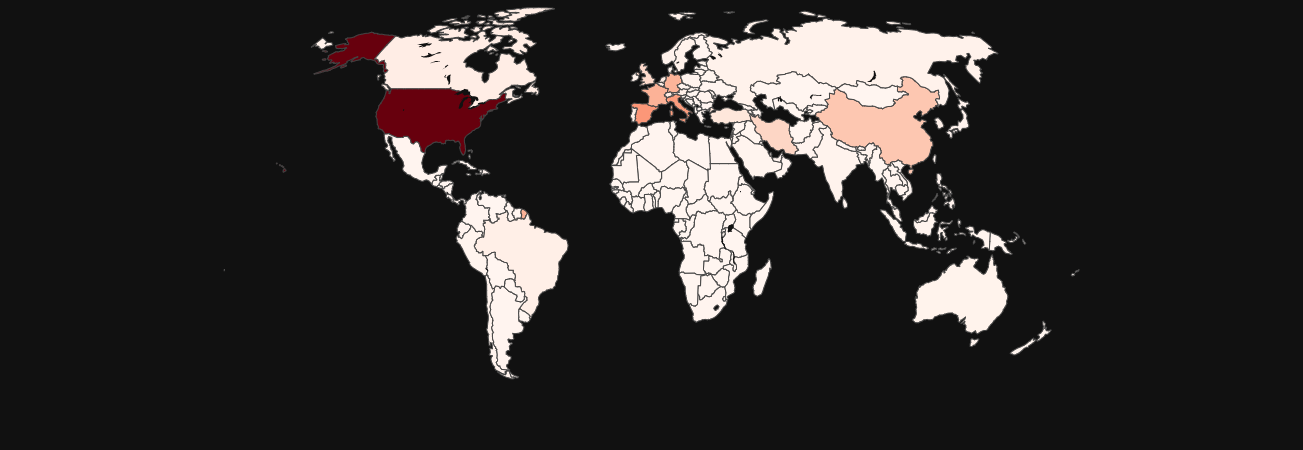

In [40]:
world_map_2()

In [41]:
def lineChart():

    # Top-10
    countries = top_10
    df_select = df[df['Country'].isin(countries)].copy()
    df_select
    fig = px.line(df_select, x="Date", y="Confirmed", color='Country')
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative Cases')
    # fig.update_traces(textposition='top center')


    # fig.update_traces(texttemplate='%{text:.2s}')
    fig.update_layout(template="plotly_dark")
    
#     fig.update_traces(hovertemplate='<b>' + df_select['Country'] +
#                           '</b>' + '<br>' + 'Date: ' +
#                           df_select['Date'].astype(str) + '<br>' +
#                           'Confirmed Cases: ' + df_select['Confirmed'].astype(str))

    fig.show()

#animation_group='Country', animation_frame=df_select.Date.astype(str)

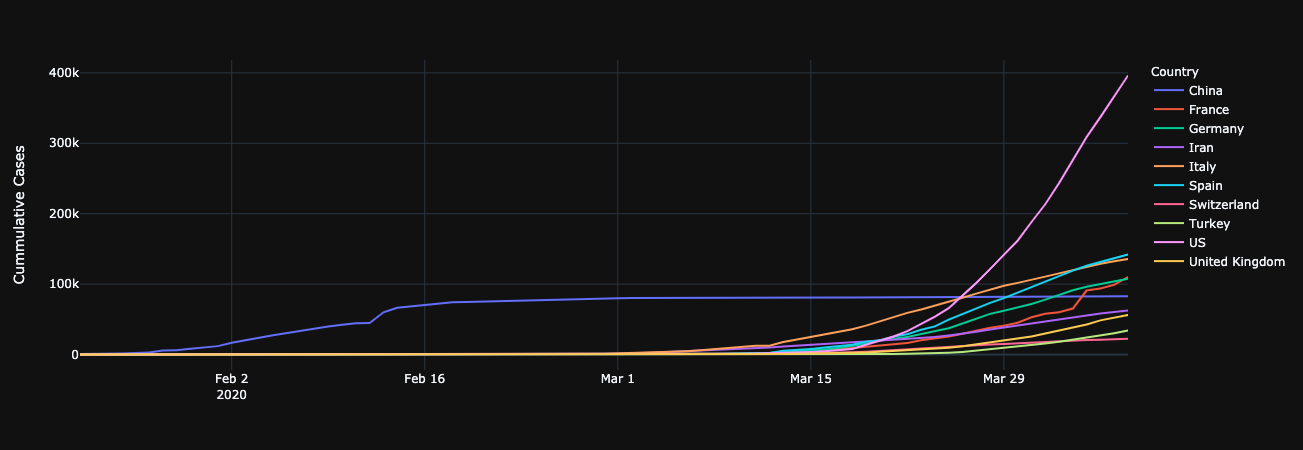

In [42]:
lineChart()

In [43]:
def perCapita():

    # Top-10
    countries = top_10
    df_select = df[df['Country'].isin(countries)].copy()
    df_select
    fig = px.line(df_select, x="Date", y="confirmedPerCapita", color='Country')
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative Cases per 100,000')
    # fig.update_traces(textposition='top center')


    # fig.update_traces(texttemplate='%{text:.2s}')
    fig.update_layout(template="plotly_dark")
    
    fig.update_traces(hovertemplate='<b>' + df_select['Country'] +
                          '</b>' + '<br>' + 'Date: ' +
                          df_select['Date'].astype(str) + '<br>' +
                          'Confirmed Cases 100,000: ' + df_select['confirmedPerCapita'].astype(str))

    return fig

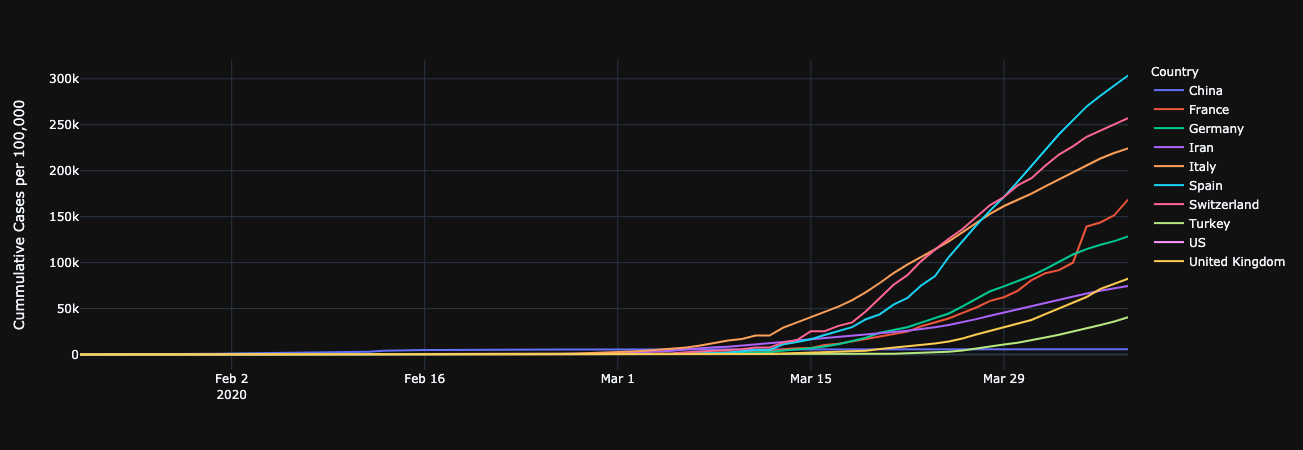

In [44]:
perCapita()

In [45]:
grouped.sum()

Country      USSpainItalyFranceGermanyChinaIranUnited Kingd...
Confirmed                                              1426096
Deaths                                                   81867
dtype: object

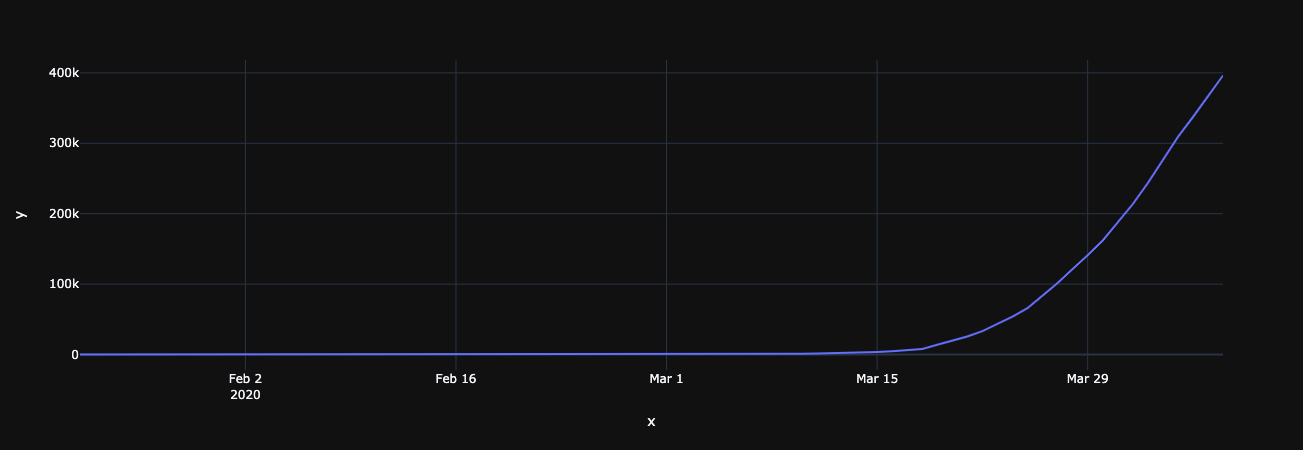

In [72]:
fig = px.line(df, x=df[df['Country'] == 'US']['Date'], y=df[df['Country'] == 'US']['Confirmed'])
fig.update_layout(template="plotly_dark")
fig.show()

In [47]:
# # Initialize figure with subplots
# fig = make_subplots(
#     rows=1, cols=2,
#     column_widths=[0.6, 0.4],
#     row_heights=[0.4, 0.6],
#     specs=[[{"type": "line", }, {"type": "bar"}]])

# # Add line chart
# fig.add_trace(
#     go.Line(x=df_select.Date,y=df_select.Confirmed, marker=dict(color="crimson"), showlegend=False),
#     row=1, col=2
# )

# # Add 3d surface of volcano
# fig.add_trace(
#     go.Surface(z=df_v.values.tolist(), showscale=False),
#     row=2, col=2
# )

# # Update geo subplot properties
# fig.update_geos(
#     projection_type="orthographic",
#     landcolor="white",
#     oceancolor="MidnightBlue",
#     showocean=True,
#     lakecolor="LightBlue"
# )

# # Rotate x-axis labels
# fig.update_xaxes(tickangle=45)

# # Set theme, margin, and annotation in layout
# fig.update_layout(
#     template="plotly_dark",
#     margin=dict(r=10, t=25, b=40, l=60),
#     annotations=[
#         dict(
#             text="Source: NOAA",
#             showarrow=False,
#             xref="paper",
#             yref="paper",
#             x=0,
#             y=0)
#     ]
# )

# fig.show()

In [48]:
#world_data.date.max()

In [49]:
df

Date             Country  Confirmed  Recovered  Deaths  \
0     2020-01-22         Afghanistan          0          0       0   
1     2020-01-22             Albania          0          0       0   
2     2020-01-22             Algeria          0          0       0   
3     2020-01-22             Andorra          0          0       0   
4     2020-01-22              Angola          0          0       0   
...          ...                 ...        ...        ...     ...   
14163 2020-04-07             Vietnam        249        123       0   
14164 2020-04-07  West Bank and Gaza        261         42       1   
14165 2020-04-07      Western Sahara          4          0       0   
14166 2020-04-07              Zambia         39          7       1   
14167 2020-04-07            Zimbabwe         11          0       2   

       population  confirmedPerCapita  deathPerCapita  
0       38928.346            0.000000        0.000000  
1        2877.797            0.000000        0.000000  
2       43851.044            0.000000        0.000000  
3          77.265            0.000000        0.000000  
4       32866.272            0.000000        0.000000  
...           ...                 ...             ...  
14163   97338.579          255.808131        0.000000  
14164         NaN                 NaN             NaN  
14165         NaN                 NaN             NaN  
14166   18383.955          212.141511        5.439526  
14167   14862.924           74.009663       13.456302  

[14168 rows x 8 columns]

In [76]:
grouped_country

Country       Date  Confirmed  Deaths  newCases  newDeaths
0      Afghanistan 2020-01-22          0       0       0.0        0.0
1      Afghanistan 2020-01-23          0       0       0.0        0.0
2      Afghanistan 2020-01-24          0       0       0.0        0.0
3      Afghanistan 2020-01-25          0       0       0.0        0.0
4      Afghanistan 2020-01-26          0       0       0.0        0.0
...            ...        ...        ...     ...       ...        ...
14163     Zimbabwe 2020-04-03          9       1       0.0        0.0
14164     Zimbabwe 2020-04-04          9       1       0.0        0.0
14165     Zimbabwe 2020-04-05          9       1       0.0        0.0
14166     Zimbabwe 2020-04-06         10       1       1.0        0.0
14167     Zimbabwe 2020-04-07         11       2       1.0        1.0

[14168 rows x 6 columns]

In [81]:
#####################
# Cummulative Cases #
#####################

def cummulativeCases(country, metric):

    fig = px.line(grouped_country, x=grouped_country[grouped_country['Country'] == country]['Date'], 
                 y=grouped_country[grouped_country['Country'] == country][metric])

    fig.update_layout(template="plotly_dark")
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative ' + metric + ' Cases')

#     fig.update_traces(hovertemplate= 'New Cases: ' + df[metric].astype(str))

    return fig

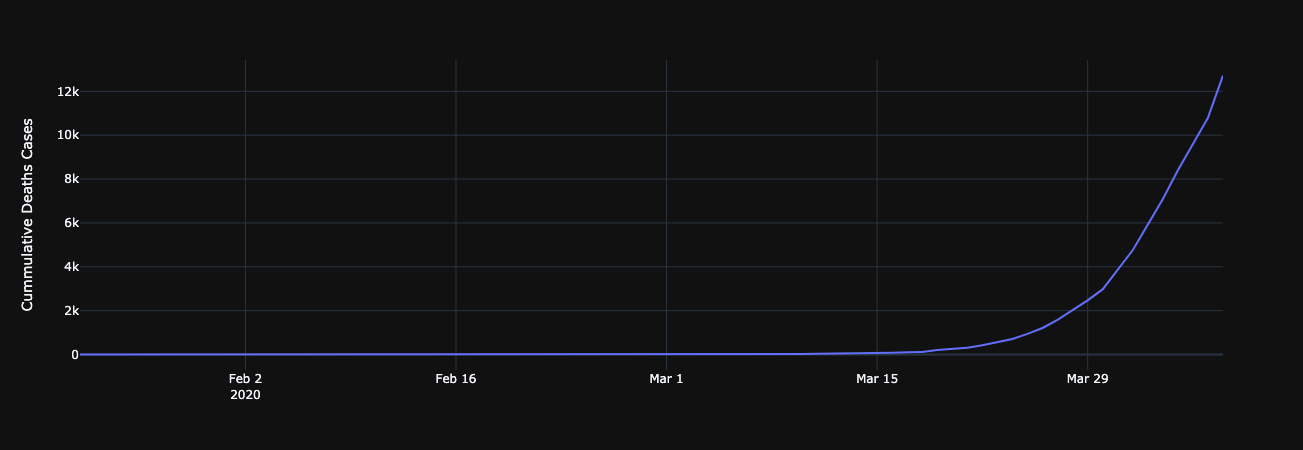

In [82]:
cummulativeCases('US', 'Deaths')

In [68]:
#####################
# New Cases per Day #
#####################

def newCases(country, metric, yaxisTitle=""):

    fig = px.bar(grouped_country,
                 x=grouped_country[grouped_country['Country'] == country]['Date'][1:],
                 y=grouped_country[grouped_country['Country'] == country]['new' + metric][1:])

    fig.update_layout(template="plotly_dark")
    fig.update_xaxes(title='')
    fig.update_yaxes(title='New Cases per Day')

    # fig.update_traces(hovertemplate='New Cases: ' +
    #                   world_data[metric].astype(str))

    return fig

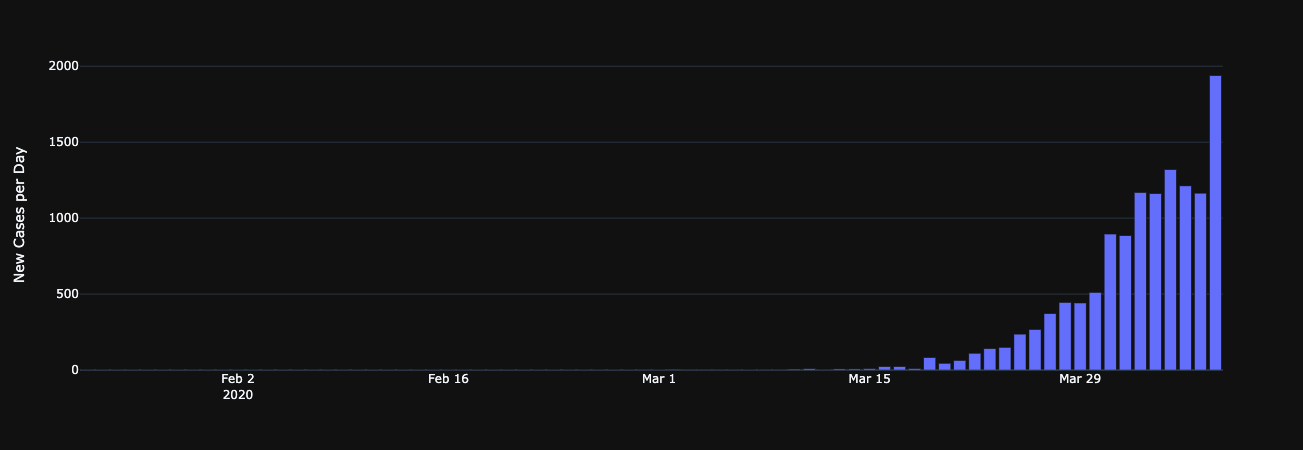

In [69]:
newCases('US', 'Deaths')

In [83]:
grouped_country[grouped_country.Country == 'US'][1:]

Country       Date  Confirmed  Deaths  newCases  newDeaths
13168      US 2020-01-23          1       0       0.0        0.0
13169      US 2020-01-24          2       0       1.0        0.0
13170      US 2020-01-25          2       0       0.0        0.0
13171      US 2020-01-26          5       0       3.0        0.0
13172      US 2020-01-27          5       0       0.0        0.0
...       ...        ...        ...     ...       ...        ...
13239      US 2020-04-03     275586    7087   31970.0     1161.0
13240      US 2020-04-04     308850    8407   33264.0     1320.0
13241      US 2020-04-05     337072    9619   28222.0     1212.0
13242      US 2020-04-06     366667   10783   29595.0     1164.0
13243      US 2020-04-07     396223   12722   29556.0     1939.0

[76 rows x 6 columns]

In [84]:
# Bar chart of fatality for top-10 countries

grouped_country['fatalityRate'] = grouped_country.Deaths/grouped_country.Confirmed*100


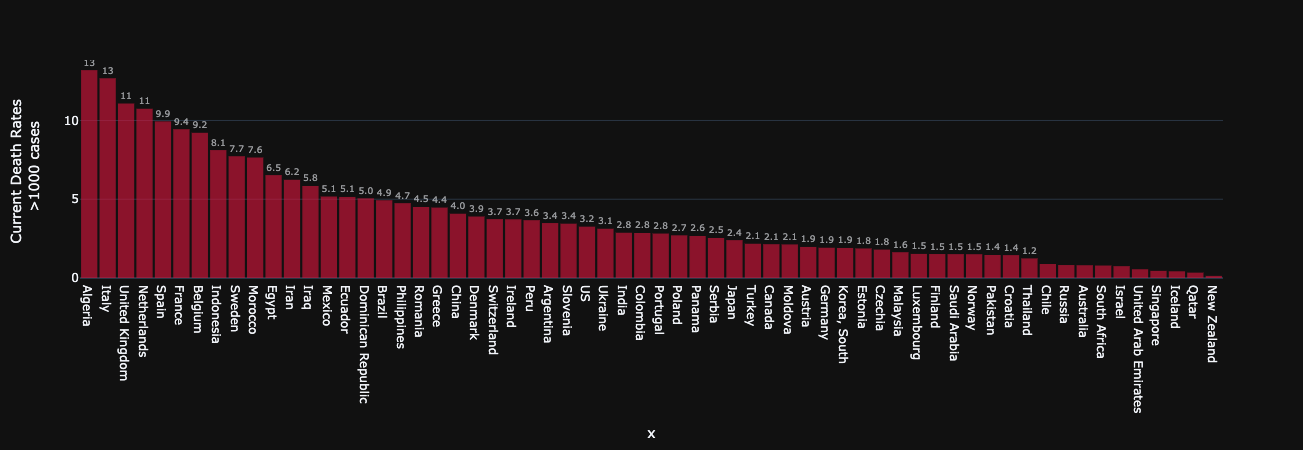

In [93]:
#################
# Fatality Rate #
#################

grouped['fatalityRate'] = grouped.Deaths/grouped.Confirmed*100

def fatalityRate():
    # Limiting graph to countries with more than 1000 cases
    x = grouped[grouped.Confirmed > 1000]["Country"]
    y = grouped[grouped.Confirmed > 1000]["fatalityRate"]

    fig = px.bar(grouped, x=x, y=y, text=grouped[grouped.Confirmed > 1000]["fatalityRate"])
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', marker_color='crimson', marker_line_color='crimson',
                      marker_line_width=1.5, opacity=0.6)
    fig.update_layout(xaxis={'categoryorder':'total descending'}, template="plotly_dark", yaxis={'title': 'Current Death Rates <br> >1000 cases'}, uniformtext_minsize=9, uniformtext_mode='hide')
    fig.show()
fatalityRate()

In [88]:
grouped

Country  Confirmed  Deaths code  fatalityRate
0                       US     396223   12722  USA      3.210818
1                    Spain     141942   14045  ESP      9.894887
2                    Italy     135586   17127  ITA     12.631835
3                   France     110065   10343  FRA      9.397174
4                  Germany     107663    2016  DEU      1.872510
..                     ...        ...     ...  ...           ...
179  Sao Tome and Principe          4       0  NaN      0.000000
180                Burundi          3       0  BDI      0.000000
181       Papua New Guinea          2       0  PNG      0.000000
182            South Sudan          2       0  SSD      0.000000
183            Timor-Leste          1       0  TLS      0.000000

[184 rows x 5 columns]